In [1]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from numpy import sqrt, random, array, argsort
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load the dataset from Google Colab files
df = pd.read_csv("machine_temperature_system_failure.csv", low_memory=False)
print(f'machine_temperature_system_failure.csv : {df.shape}')
df.head(3)


machine_temperature_system_failure.csv : (22695, 2)


,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162


In [3]:
df.shape

(22695, 2)

# preprocessing

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


In [5]:
 print(' duplicated rows: ', df.duplicated().sum())

 duplicated rows:  0


Text(20000, 35, 'INTERESTING POING')

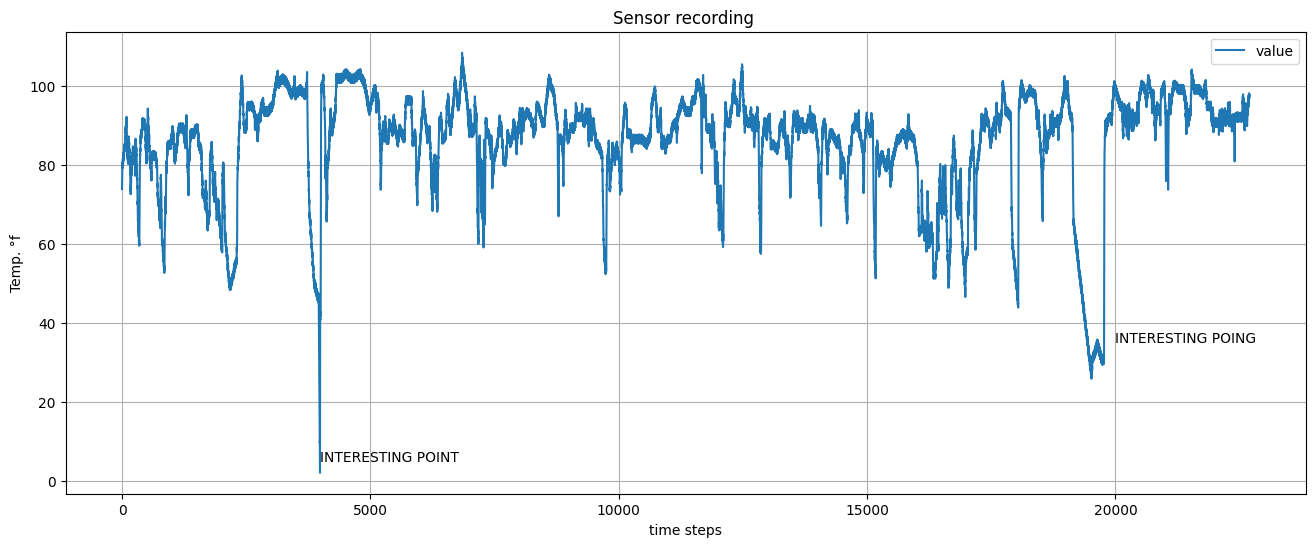

In [6]:
df.plot(xlabel = 'time steps', ylabel = 'Temp. °f', figsize = (16,6), grid = True, title = 'Sensor recording ', )
plt.annotate('INTERESTING POINT', (3987,5))
plt.annotate('INTERESTING POING', (20000,35))

In [9]:
df.describe()

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


The code you provided is preparing the data for autoregression, which involves using previous time steps as input features for predicting the current time step. Here's an explanation of each step:

- Creating Lag Features: In autoregression, the value of a variable at a particular time step is modeled as a function of the values of the same variable at previous time steps. To achieve this, new features (columns) are created by shifting the values of the original variable (in this case, 'value') by a specified number of time steps. For example:

-- df['x1'] = df['value'].shift(+1) shifts the values of the 'value' column by one time step and assigns them to a new column 'x1'.

-- df['x2'] = df['value'].shift(+2) shifts the values of the 'value' column by two time steps and assigns them to a new column 'x2'.

- Handling NaN Values: Shifting the values results in NaN (Not a Number) values for the first few rows because there are no previous values available for those time steps. For example, after shifting by one time step, the first row will have a NaN value in the 'x1' column because there is no value from the previous time step to shift into that row. Similarly, the first two rows will have NaN values in the 'x2' column.

- Dropping NaN Rows: Since the NaN values in the first few rows cannot be used as input for the autoregression model (as there are no previous values available), those rows are dropped from the DataFrame using df.dropna(inplace=True). This ensures that only rows with valid lag features are retained for training the model.

By creating lag features and handling NaN values in this way, the DataFrame is prepared for autoregression modeling, where each row contains the current value along with the values from the previous time steps that will serve as input features for predicting the current value.

In [10]:
# since we are going to make an autoregression, we are going to need to add temperature readings from the instants before that will do as input for the model,
# this way the model will learn the actual value and how its related to the previus values.

df['x1']= df['value'].shift(+1)
df['x2'] = df['value'].shift(+2)

In [11]:
df.dropna(inplace = True)

these steps prepare the lag features (x1 and x2) and the target variable (y) as NumPy arrays and format them properly for training an autoregression model.

In [12]:
x1,x2,y = df['x1'],df['x2'], df['value']
x1,x2, y = np.array(x1), np.array(x2), np.array(y)
x1, x2,  y = x1.reshape(-1,1), x2.reshape(-1,1),  y.reshape(-1,1)
joined_x = np.concatenate((x1, x2), axis = 1)

In [13]:
#confirming the shape of the x variable matrix
joined_x.shape

(22693, 2)

In [14]:
# Time to split the dataset, 0.80 for training, 0.20 for testing, we do this by the index.
split_time = 18154
X_train = joined_x[:split_time]
y_train = y[: split_time]
x_test = joined_x[split_time:]
y_test = y[ split_time:]

In [15]:
X_train

array([[74.935882  , 73.96732207],
       [76.12416182, 74.935882  ],
       [78.14070732, 76.12416182],
       ...,
       [97.36342451, 97.23551447],
       [98.96303401, 97.36342451],
       [98.75092685, 98.96303401]])

# create the regressor object and train it

In [16]:
regressor = LinearRegression()
regressor.fit( X_train, y_train)
y_pred = regressor.predict(x_test)

In [17]:
# a quick look to the predictions
y_pred

array([[98.17980865],
       [98.53995842],
       [97.28495707],
       ...,
       [97.85695643],
       [97.25780886],
       [97.80324632]])

In [18]:
# aquick look to the real values
y_test

array([[98.74076344],
       [96.88282423],
       [98.84176116],
       ...,
       [97.13546835],
       [98.05685212],
       [96.90386085]])

<Axes: title={'center': 'Linear regression prediction '}, xlabel='time steps', ylabel='Temp. °f'>

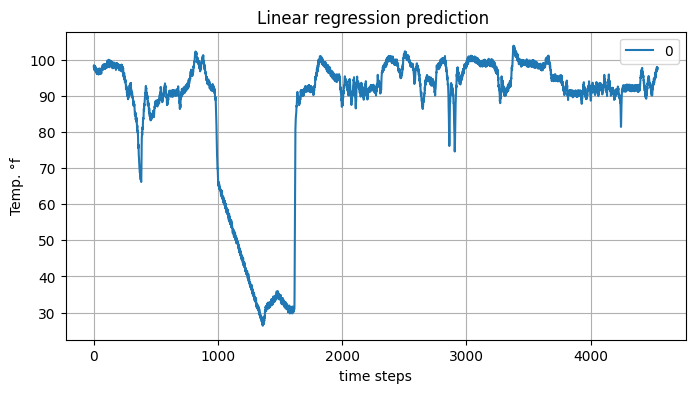

In [19]:
# ploting Predicted result of regression

pd.DataFrame(y_pred).plot(xlabel = 'time steps', ylabel = 'Temp. °f', figsize = (8,4), grid = True, title = 'Linear regression prediction ', )

<Axes: title={'center': 'Real values '}, xlabel='time steps', ylabel='Temp. °f'>

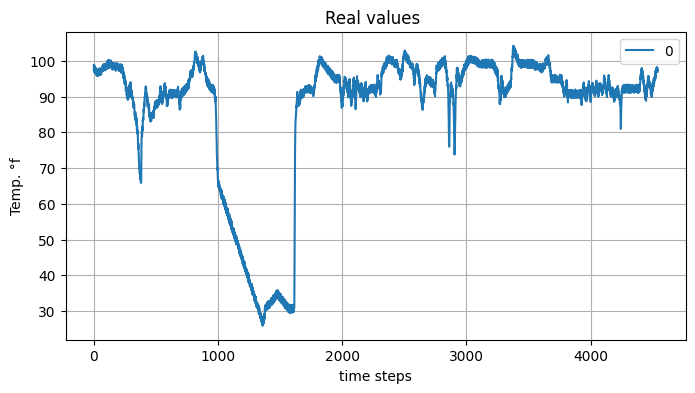

In [20]:
# ploting Real Values
pd.DataFrame(y_test).plot(xlabel = 'time steps', ylabel = 'Temp. °f', figsize = (8,4), grid = True, title = 'Real values ',)

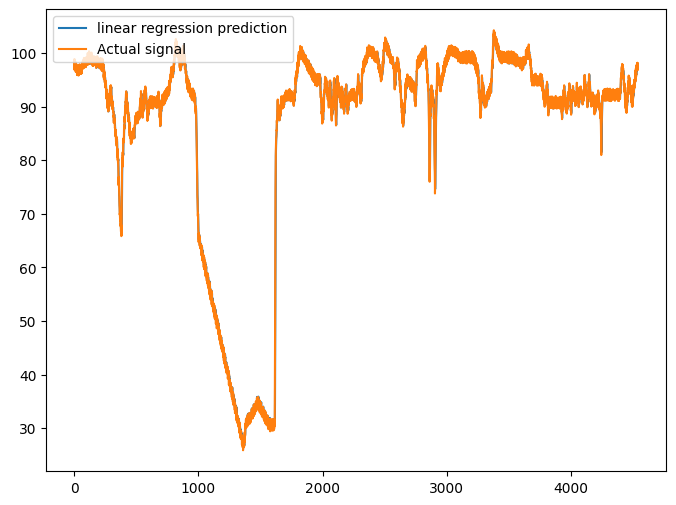

In [21]:
# plot real and regresion model
plt.figure(figsize=(8, 6),)
plt.plot(y_pred, label = 'linear regression prediction')
plt.plot(y_test, label = 'Actual signal')
plt.legend(loc = "upper left")
plt.show()

In [22]:
r2_score(y_test,y_pred)

0.9973316401344382

# ensemble method: random forest  ---> to decrease overfitting

In [24]:
df_copy = df.copy()

In [25]:
#dropping the timestamp columnfrom the dataframe copy
df_copy.drop( columns = ['timestamp'], inplace= True)

In [26]:
df_copy

,value,x1,x2
2,76.124162,74.935882,73.967322
3,78.140707,76.124162,74.935882
4,79.329836,78.140707,76.124162
5,78.710418,79.329836,78.140707
6,80.269784,78.710418,79.329836
...,...,...,...
22690,98.185415,97.360905,98.162952
22691,97.804168,98.185415,97.360905
22692,97.135468,97.804168,98.185415
22693,98.056852,97.135468,97.804168


#  make a randomforest regressor object and then Training

In [27]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, np.ravel(y_train))
tree_pred = regr.predict(x_test)

<Axes: title={'center': ' Random forest regression prediction '}, xlabel='time steps', ylabel='Temp. °f'>

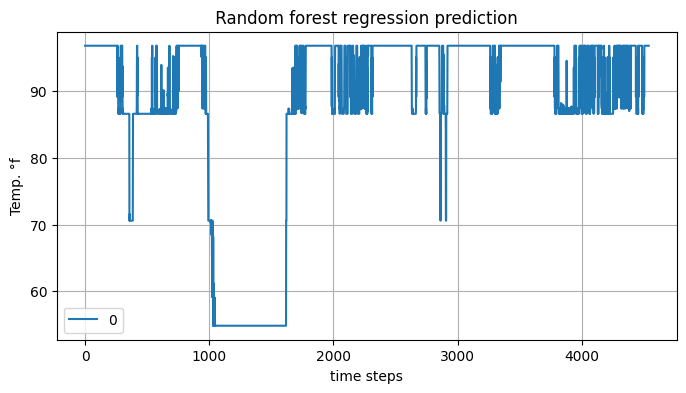

In [28]:
# ploting Ransom Forest Regression Prediction
pd.DataFrame(tree_pred).plot(xlabel = 'time steps', ylabel = 'Temp. °f', figsize = (8,4), grid = True, title = ' Random forest regression prediction ', )

**compare the random forest prediction versus the real values.**

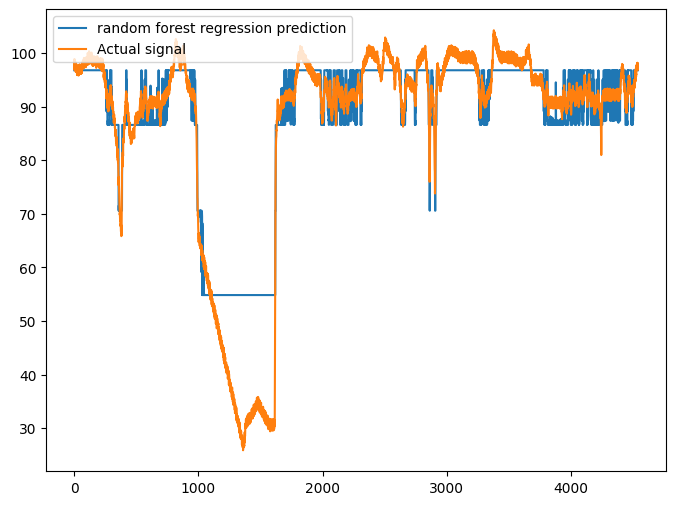

In [29]:
plt.figure(figsize=(8, 6))
plt.plot(tree_pred, label = 'random forest regression prediction')
plt.plot(y_test, label = 'Actual signal')
plt.legend(loc = "upper left")
plt.show()

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(regr, X_train, np.ravel(y_train), scoring='r2', cv=folds)
scores

array([0.89897524, 0.90020176, 0.88616735, 0.88883924, 0.89648379])

# Anomaly Detection with K-means

how K-means can help find anomalies in a signal:

Understanding K-means:

K-means is an unsupervised machine learning algorithm used for clustering data points into a predetermined number of clusters (K). It aims to partition the data into clusters in such a way that the within-cluster variance is minimized.

- Using K-means for Anomaly Detection:

In the context of anomaly detection in a signal, K-means can be used to  **cluster similar** data points together. Anomalies, being different from normal data points, may not fit well into any cluster and might be detected as outliers or in clusters with significantly different characteristics.

Finding Centroids:

After applying K-means to the signal data, the algorithm will find K centroids, which represent the centers of the clusters. These centroids represent typical patterns or behaviors within the signal.


Identifying Anomalies:

Anomalies in the signal data are often data points that do not belong to any of the clusters or are significantly different from the centroids. These anomalies may indicate unusual patterns, events, or errors in the signal.


Thresholding or Distance Measures:

Once the clusters and centroids are obtained, various methods can be used to identify anomalies. For example, anomalies may be detected based on their distance from the nearest centroid or by defining a threshold on certain cluster properties (e.g., cluster size, density).

Evaluation and Refinement:

It's important to evaluate the performance of the anomaly detection approach using appropriate metrics and refine the parameters (e.g., number of clusters, distance threshold) if necessary to improve detection accuracy.
In summary, K-means can be a useful tool for detecting anomalies in a signal by clustering similar data points together and identifying data points that deviate significantly from the clusters' centroids. However, it's essential to carefully interpret the results and tune the algorithm parameters based on the specific characteristics of the signal and the types of anomalies expected.








In [31]:
kmeans = KMeans(n_clusters = 1).fit(df_copy)
print(kmeans)
print((mean_squared_error(tree_pred, y_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=1)
53.682911361180324


In [32]:
center = kmeans.cluster_centers_
print(center)

[[85.92750953 85.92654148 85.92547994]]


In [33]:
# calculate the distance from the center of each reading in the dataset
distance = sqrt((df_copy - center)**2)

In [34]:
distance

,value,x1,x2
2,9.803348,10.990659,11.958158
3,7.786802,9.802380,10.989598
4,6.597674,7.785834,9.801318
5,7.217091,6.596706,7.784773
6,5.657725,7.216123,6.595644
...,...,...,...
22690,12.257905,11.434363,12.237472
22691,11.876659,12.258873,11.435425
22692,11.207959,11.877627,12.259935
22693,12.129343,11.208927,11.878689


In [35]:
#variable to determine how many farthest points we will label as anomalies
number_of_points = 25

In [36]:
# sort them to find the farthest points from the center, and locate their indexes
order_index = argsort(distance, axis = 0)
indexes = order_index[-number_of_points:].values
index_values = []

In [37]:
# create a list index_values and then values

for i in indexes:
    index_values.append(i[0])

In [38]:
values = [df_copy.iloc[i] for i in index_values]

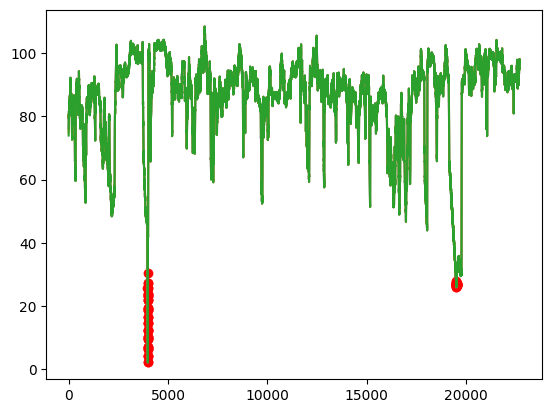

In [39]:
# we plot the location of the 2 anomalies found
plt.plot(df_copy)
plt.scatter(indexes, values, color='r')
plt.show()